In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

storage = paths.storage.Storage("mstis.nc")

In [2]:
mstis = storage.networks.load(0)

In [3]:
# these things speed up the analysis
storage.samples.cache_all()
storage.samplesets.cache_all()
storage.pathmovechanges.cache_all()
storage.steps.cache_all()
map(lambda x : x.cache_all(storage), storage.cvs)

[None, None, None]

## Reaction rates

TIS methods are especially good at determining reaction rates, and OPS makes it extremely easy to obtain the rate from a TIS network.

Note that, although you can get the rate directly, it is very important to look at other results of the sampling (illustrated in this notebook and in notebooks referred to herein) in order to check the validity of the rates you obtain.

By default, the built-in analysis calculates histograms the maximum value of some order parameter and the pathlength of every sampled ensemble. You can add other things to this list as well, but you must always specify histogram parameters for these two. The pathlength is in units of frames.

In [4]:
mstis.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (0.0, 0.5) }
mstis.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }

In [5]:
mstis.special_ensembles['minus']

{<openpathsampling.ensemble.MinusInterfaceEnsemble at 0x10f033110>: [<openpathsampling.analysis.tis_analysis.RETISTransition at 0x1178d4d50>],
 <openpathsampling.ensemble.MinusInterfaceEnsemble at 0x117a18890>: [<openpathsampling.analysis.tis_analysis.RETISTransition at 0x117a18090>],
 <openpathsampling.ensemble.MinusInterfaceEnsemble at 0x117a45e50>: [<openpathsampling.analysis.tis_analysis.RETISTransition at 0x117a451d0>]}

In [6]:
mstis.transitions.values()[0].minus_ensemble

In [7]:
mstis.rate_matrix(storage)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


,"{x|opA(x) in [0.0, 0.04]}","{x|opB(x) in [0.0, 0.04]}","{x|opC(x) in [0.0, 0.04]}"
"{x|opA(x) in [0.0, 0.04]}",NaN,NaN,NaN
"{x|opB(x) in [0.0, 0.04]}",NaN,NaN,NaN
"{x|opC(x) in [0.0, 0.04]}",NaN,NaN,NaN


The self-rates (the rate of returning the to initial state) are undefined, and return not-a-number.

The rate is calcuated according to the formula:

$$k_{AB} = \phi_{A,0} P(B|\lambda_m) \prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$$

where $\phi_{A,0}$ is the flux from state A through its innermost interface, $P(B|\lambda_m)$ is the conditional transition probability (the probability that a path which crosses the interface at $\lambda_m$ ends in state B), and $\prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$ is the total crossing probability. We can look at each of these terms individually.

### Total crossing probability

In [8]:
stateA = storage.volumes.find_first("A")
stateB = storage.volumes.find_first("B")
stateC = storage.volumes.find_first("C")

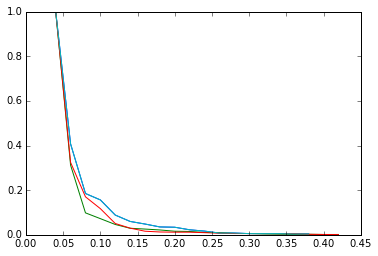

In [9]:
tcp_AB = mstis.transitions[(stateA, stateB)].tcp
tcp_AC = mstis.transitions[(stateA, stateC)].tcp
tcp_BC = mstis.transitions[(stateB, stateC)].tcp
tcp_BA = mstis.transitions[(stateB, stateA)].tcp
tcp_CA = mstis.transitions[(stateC, stateA)].tcp
tcp_CB = mstis.transitions[(stateC, stateB)].tcp

plt.plot(tcp_AB.x, tcp_AB)
plt.plot(tcp_CA.x, tcp_CA)
plt.plot(tcp_BC.x, tcp_BC)
plt.plot(tcp_AC.x, tcp_AC) # same as tcp_AB in MSTIS

We normally look at these on a log scale:

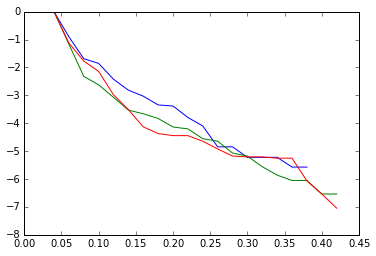

In [10]:
plt.plot(tcp_AB.x, np.log(tcp_AB))
plt.plot(tcp_CA.x, np.log(tcp_CA))
plt.plot(tcp_BC.x, np.log(tcp_BC))

### Flux

In [11]:
import pandas as pd
flux_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    flux_matrix.set_value(state_pair[0], state_pair[1], transition._flux)

flux_matrix

,"{x|opA(x) in [0.0, 0.04]}","{x|opB(x) in [0.0, 0.04]}","{x|opC(x) in [0.0, 0.04]}"
"{x|opA(x) in [0.0, 0.04]}",NaN,NaN,NaN
"{x|opB(x) in [0.0, 0.04]}",NaN,NaN,NaN
"{x|opC(x) in [0.0, 0.04]}",NaN,NaN,NaN


### Conditional transition probability

In [12]:
outer_ctp_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    outer_ctp_matrix.set_value(state_pair[0], state_pair[1], transition.ctp[transition.ensembles[-1]])    

outer_ctp_matrix

,"{x|opA(x) in [0.0, 0.04]}","{x|opB(x) in [0.0, 0.04]}","{x|opC(x) in [0.0, 0.04]}"
"{x|opA(x) in [0.0, 0.04]}",NaN,0.1857628,0.3937213
"{x|opB(x) in [0.0, 0.04]}",0.2639472,NaN,0.2135573
"{x|opC(x) in [0.0, 0.04]}",0.1239752,0.2439512,NaN


In [13]:
ctp_by_interface = pd.DataFrame(index=mstis.transitions)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    for ensemble_i in range(len(transition.ensembles)):
        ctp_by_interface.set_value(
            state_pair, ensemble_i,
            transition.conditional_transition_probability(
                storage,
                transition.ensembles[ensemble_i]
        ))
    
    
ctp_by_interface  

,0,1,2
"({x|opB(x) in [0.0, 0.04]}, {x|opC(x) in [0.0, 0.04]})",0.0006,0.020996,0.213557
"({x|opC(x) in [0.0, 0.04]}, {x|opA(x) in [0.0, 0.04]})",0.0000,0.024195,0.123975
"({x|opC(x) in [0.0, 0.04]}, {x|opB(x) in [0.0, 0.04]})",0.0020,0.099180,0.243951
"({x|opA(x) in [0.0, 0.04]}, {x|opB(x) in [0.0, 0.04]})",0.0000,0.087183,0.185763
"({x|opB(x) in [0.0, 0.04]}, {x|opA(x) in [0.0, 0.04]})",0.0000,0.003999,0.263947
"({x|opA(x) in [0.0, 0.04]}, {x|opC(x) in [0.0, 0.04]})",0.0000,0.119576,0.393721


## Path ensemble properties

In [14]:
hists_A = mstis.transitions[(stateA, stateB)].histograms
hists_B = mstis.transitions[(stateB, stateC)].histograms
hists_C = mstis.transitions[(stateC, stateB)].histograms

### Interface crossing probabilities

We obtain the total crossing probability, shown above, by combining the individual crossing probabilities of 

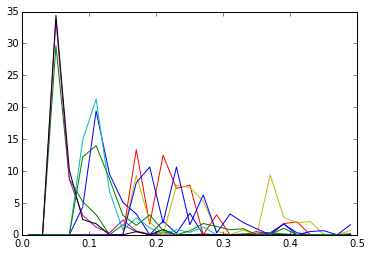

In [15]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        normalized = hist['max_lambda'][ens].normalized()
        plt.plot(normalized.x, normalized)

In [16]:
# add visualization of the sum

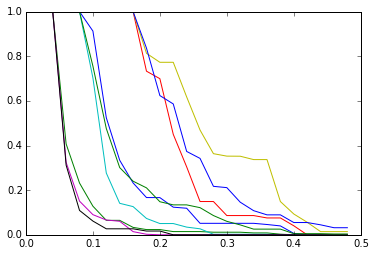

In [17]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, reverse_cumulative)

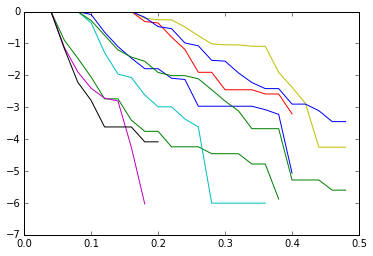

In [18]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, np.log(reverse_cumulative))

### Path length histograms

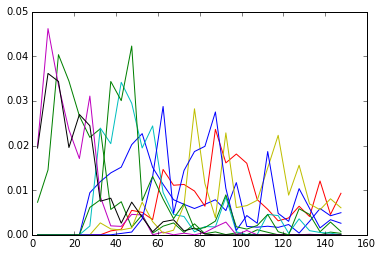

In [19]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['pathlength']:
        normalized = hist['pathlength'][ens].normalized()
        plt.plot(normalized.x, normalized)

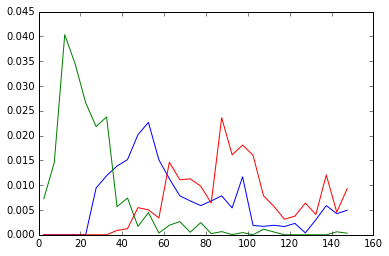

In [20]:
for ens in hists_A['pathlength']:
    normalized = hists_A['pathlength'][ens].normalized()
    plt.plot(normalized.x, normalized)

## Sampling properties

The properties we illustrated above were properties of the path ensembles. If your path ensembles are sufficiently well-sampled, these will never depend on how you sample them.

But to figure out whether you've done a good job of sampling, you often want to look at properties related to the sampling process. OPS also makes these very easy.

### Move scheme analysis

In [30]:
scheme = paths.MoveScheme(mstis)

In [29]:
scheme.move_summary(storage)

ms_outer_shooting ran 3.61927614477% of the cycles with acceptance 130/181 (0.718232044199)
repex ran 18.1363727255% of the cycles with acceptance 183/907 (0.201764057332)
msouter_shooting ran 3.81923615277% of the cycles with acceptance 141/191 (0.738219895288)
msouter_pathreversal ran 3.87922415517% of the cycles with acceptance 194/194 (1.0)
msouter_repex ran 12.0175964807% of the cycles with acceptance 143/601 (0.237936772047)
shooting ran 36.1927614477% of the cycles with acceptance 1339/1810 (0.739779005525)
minus ran 2.61947610478% of the cycles with acceptance 128/131 (0.977099236641)
pathreversal ran 19.6960607878% of the cycles with acceptance 818/985 (0.830456852792)


In [23]:
scheme.move_summary(storage, 'shooting')

OneWayShootingMover I'face 2 ran 4.15916816637% of the cycles with acceptance 135/208 (0.649038461538)
OneWayShootingMover I'face 1 ran 4.23915216957% of the cycles with acceptance 155/212 (0.731132075472)
OneWayShootingMover I'face 1 ran 4.09918016397% of the cycles with acceptance 159/205 (0.775609756098)
OneWayShootingMover I'face 0 ran 4.03919216157% of the cycles with acceptance 162/202 (0.80198019802)
OneWayShootingMover I'face 0 ran 3.91921615677% of the cycles with acceptance 159/196 (0.811224489796)
OneWayShootingMover I'face 1 ran 3.91921615677% of the cycles with acceptance 142/196 (0.724489795918)
OneWayShootingMover I'face 0 ran 4.09918016397% of the cycles with acceptance 161/205 (0.785365853659)
OneWayShootingMover I'face 2 ran 3.91921615677% of the cycles with acceptance 144/196 (0.734693877551)
OneWayShootingMover I'face 2 ran 3.79924015197% of the cycles with acceptance 122/190 (0.642105263158)


In [31]:
scheme.move_summary(storage, 'minus')

Minus ran 0.979804039192% of the cycles with acceptance 49/49 (1.0)
Minus ran 0.619876024795% of the cycles with acceptance 29/31 (0.935483870968)
Minus ran 1.01979604079% of the cycles with acceptance 50/51 (0.980392156863)


In [33]:
scheme.move_summary(storage, 'repex')

ReplicaExchange ran 1.83963207359% of the cycles with acceptance 18/92 (0.195652173913)
ReplicaExchange ran 2.01959608078% of the cycles with acceptance 21/101 (0.207920792079)
ReplicaExchange ran 2.25954809038% of the cycles with acceptance 28/113 (0.247787610619)
ReplicaExchange ran 2.07958408318% of the cycles with acceptance 38/104 (0.365384615385)
ReplicaExchange ran 1.89962007598% of the cycles with acceptance 3/95 (0.0315789473684)
ReplicaExchange ran 1.99960007998% of the cycles with acceptance 19/100 (0.19)
ReplicaExchange ran 1.77964407119% of the cycles with acceptance 13/89 (0.14606741573)
ReplicaExchange ran 2.11957608478% of the cycles with acceptance 5/106 (0.0471698113208)
ReplicaExchange ran 2.13957208558% of the cycles with acceptance 38/107 (0.355140186916)


In [34]:
scheme.move_summary(storage, 'pathreversal')

PathReversal ran 1.81963607279% of the cycles with acceptance 91/91 (1.0)
PathReversal ran 1.89962007598% of the cycles with acceptance 51/95 (0.536842105263)
PathReversal ran 1.95960807838% of the cycles with acceptance 51/98 (0.520408163265)
PathReversal ran 1.83963207359% of the cycles with acceptance 89/92 (0.967391304348)
PathReversal ran 2.15956808638% of the cycles with acceptance 108/108 (1.0)
PathReversal ran 1.99960007998% of the cycles with acceptance 100/100 (1.0)
PathReversal ran 1.67966406719% of the cycles with acceptance 73/84 (0.869047619048)
PathReversal ran 1.85962807439% of the cycles with acceptance 93/93 (1.0)
PathReversal ran 2.07958408318% of the cycles with acceptance 71/104 (0.682692307692)
PathReversal ran 2.39952009598% of the cycles with acceptance 91/120 (0.758333333333)


### Replica exchange sampling

See the notebook `repex_networks.ipynb` for more details on tools to study the convergence of replica exchange. However, a few simple examples are shown here. All of these are analyzed with a separate object, `ReplicaNetwork`.

In [ ]:
repx_net = paths.ReplicaNetwork(storage=storage)

#### Replica exchange mixing matrix

In [ ]:
repx_net.mixing_matrix()

#### Replica exchange graph

The mixing matrix tells a story of how well various interfaces are connected to other interfaces. The replica exchange graph is essentially a visualization of the mixing matrix (actually, of the transition matrix -- the mixing matrix is a symmetrized version of the transition matrix).

Note: We're still developing better layout tools to visualize these.

In [ ]:
repxG = paths.ReplicaNetworkGraph(repx_net)
repxG.draw('spring')

#### Replica exchange flow

Replica flow is defined as ***TODO***

Flow is designed for calculations where the replica exchange graph is linear, which ours clearly is not. However, we can define the flow over a subset of the interfaces.

### Replica move history tree

In [ ]:
# get cases from the first 100 steps that used given ensemble
ensemble = mstis.transitions[(stateA, stateB)].ensembles[0]

# identify the replica initially associated with that ensemble
sample = storage.steps[0].active[ensemble]
replica = sample.replica

first_samples = [sample]
for step in storage.steps[0:500]:
    first_samples.extend([s for s in step.change.trials if s.replica==replica])

In [ ]:
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

tree = PathTreeBuilder(storage)
tree.rejected = False
tree.from_samples(first_samples)
view = tree.renderer
view.zoom = 0.8
view.scale_y = 24
view.scale_x = 14
view.font_size = 0.35

In [ ]:
SVG(view.to_svg())

In [ ]:
prev = first_samples[0].trajectory
decorrelated = [prev]
for s in first_samples:
    if not paths.Trajectory.is_correlated(s.trajectory, prev):
        decorrelated.append(s.trajectory)
        prev = s.trajectory
print "We have " + str(len(decorrelated)) + " decorrelated trajectories."

## Visualizing in CV space

The live_visualization tools allow both visualization of 

### Visualizing trajectories

In [ ]:
from toy_plot_helpers import ToyPlot
background = ToyPlot()
background.contour_range = np.arange(-1.5, 1.0, 0.1)
background.add_pes(storage.engines[0].pes)

In [ ]:
xval = paths.CV_Function("xval", lambda snap : snap.xyz[0][0])
yval = paths.CV_Function("yval", lambda snap : snap.xyz[0][1])
vis = paths.LiveVisualization(mstis, xval, yval, [-1.0, 1.0], [-1.0, 1.0])
vis.background = background.plot()

In [ ]:
vis.draw_samples(first_samples)

In [ ]:
import time
max_step = 10
for step in storage.steps[0:max_step]:
    vis.draw_ipynb(step)
    time.sleep(0.1)

## Histogramming data (TODO)